In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.preprocessing import minmax_scale
import random
import cv2


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation

In [2]:
df_train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
df_sample = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
display(df_train.sample(3))
print(df_train.shape)

,image_id,label
2651,1461335818.jpg,3
473,108428649.jpg,3
16504,3966975834.jpg,2


(21397, 2)


In [3]:
df_train['label'] = df_train['label'].astype('str')
display(df_train.head())

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
n_classes = 5
batch_size = 64
img_size = 224
n_epochs = 30

In [5]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

image_generator = ImageDataGenerator(
        validation_split=0.15,
        horizontal_flip=True,
        vertical_flip = True,
        rotation_range=30,
        zoom_range = 0.25,
        shear_range = 0.15,
        fill_mode='nearest'
)

train_generator = image_generator.flow_from_dataframe(
    dataframe = df_train,
        directory='../input/cassava-leaf-disease-classification/train_images',
        x_col = 'image_id',
        y_col = 'label',     
        target_size=(img_size, img_size),
        batch_size=batch_size,
        subset='training',
        class_mode='sparse')



image_generator_valid = ImageDataGenerator(validation_split=0.15)


valid_generator=image_generator_valid.flow_from_dataframe(
    dataframe = df_train,
    directory='../input/cassava-leaf-disease-classification/train_images',
    x_col = 'image_id',
    y_col = 'label', 
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='sparse') 

Found 18188 validated image filenames belonging to 5 classes.
Found 3209 validated image filenames belonging to 5 classes.


In [6]:
base_model = VGG16(input_shape=(img_size,img_size,3),
                  include_top=False,
                  weights='imagenet')

58892288/58889256 [==============================] - 1s 0us/step


In [7]:
for layer in base_model.layers:
    layer.trainable = False

In [8]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(n_classes,activation='softmax')(x)
model = Model(base_model.input,output)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [9]:
rlr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 2, verbose = 0, 
                                min_delta = 0.0001, min_lr = 0.00001, mode = 'max')

ckp = ModelCheckpoint('./model.h5',monitor = 'val_accuracy',
                      verbose = 0, save_best_only = True, mode = 'max')

es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0001, patience = 5, mode = 'max', 
                    restore_best_weights = True, verbose = 0)

In [10]:
history = model.fit_generator(generator=train_generator,                      
                    validation_data=valid_generator,                                       
                    epochs=n_epochs,
                    callbacks=[rlr,es,ckp],
                    verbose=1)

Epoch 1/30
285/285 [==============================] - 509s 2s/step - loss: 3.9205 - accuracy: 0.5987 - val_loss: 0.9584 - val_accuracy: 0.6229
Epoch 2/30
285/285 [==============================] - 402s 1s/step - loss: 1.0921 - accuracy: 0.6170 - val_loss: 0.9262 - val_accuracy: 0.6220
Epoch 3/30
285/285 [==============================] - 409s 1s/step - loss: 1.0601 - accuracy: 0.6155 - val_loss: 0.9370 - val_accuracy: 0.6186
Epoch 4/30
285/285 [==============================] - 415s 1s/step - loss: 1.0282 - accuracy: 0.6152 - val_loss: 0.9276 - val_accuracy: 0.6201
Epoch 5/30
285/285 [==============================] - 410s 1s/step - loss: 1.0191 - accuracy: 0.6154 - val_loss: 0.9301 - val_accuracy: 0.6204
Epoch 6/30
285/285 [==============================] - 389s 1s/step - loss: 1.0065 - accuracy: 0.6151 - val_loss: 0.9284 - val_accuracy: 0.6208


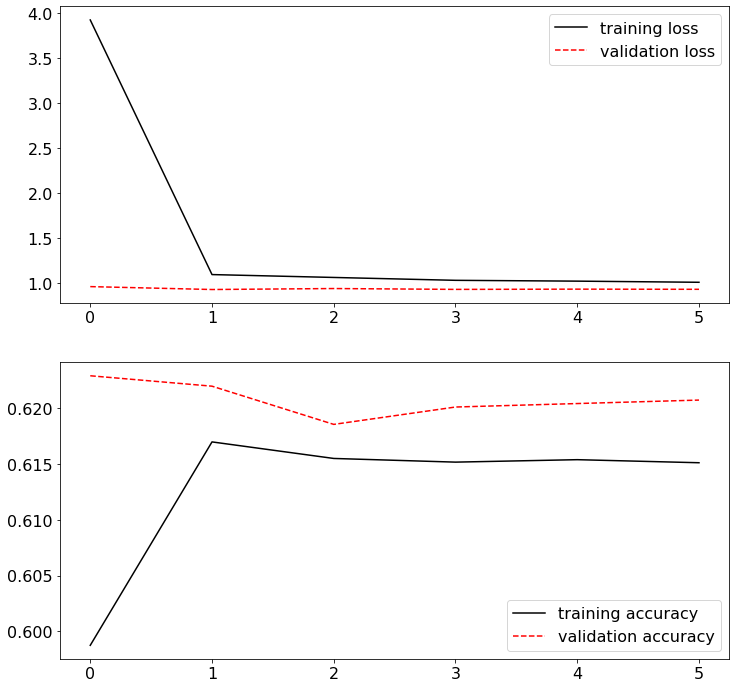

In [11]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
hist = pd.DataFrame(history.history)
fig, (ax1, ax2) = plt.subplots(figsize=(12,12),nrows=2, ncols=1)
hist['loss'].plot(ax=ax1,c='k',label='training loss')
hist['val_loss'].plot(ax=ax1,c='r',linestyle='--', label='validation loss')
ax1.legend()
hist['accuracy'].plot(ax=ax2,c='k',label='training accuracy')
hist['val_accuracy'].plot(ax=ax2,c='r',linestyle='--',label='validation accuracy')
ax2.legend()
plt.show()